In [2]:
import numpy as np
from scipy.sparse import csr_matrix, load_npz, save_npz
import os
import pandas as pd
import matplotlib.pyplot as plt

MUNI = 0
SEED = 0
RUN= 0
DEMO = 5
NDAYS = 1

path = os.getcwd() + '\Data\Model_V1\Data\High/'
pathhigh = os.getcwd() 

seeds = [f'{path}/Seed_v3_{x}' for x in [SEED]]
seed_ids = np.arange(5)

pathconstant = 'Runs_High_0.5_100_3.2_risk'

seeddicts = []
seed_extraPeopleDF = []
seed_peopleDF = []
seed_positions = []
for seed in [SEED]: 
    pathseed = pathhigh + f'/Seed_v3_{seed}/'
    peopleDF = pd.read_pickle(pathseed + 'PeopleDF.pkl')
    extraPeopleDF = pd.read_pickle(pathseed +'ExtraPeopleDF.pkl')
    positions = np.load(pathseed + 'Positions.npy')
    seed_positions.append(positions)
    uniLocs = np.array(pd.read_pickle(os.path.normpath('Data/Model_V1/Data/Gemeenten.pkl'))).T[0]
    loc_to_id = {val: i for i, val in enumerate(uniLocs)}
    uniGroups = np.unique(np.array(extraPeopleDF.Group))
    seeddicts.append(loc_to_id)
    seed_extraPeopleDF.append(extraPeopleDF)
    seed_peopleDF.append(peopleDF)
    seed_positions.append(positions)

In [3]:
demo = DEMO
timesteps = NDAYS*24

In [4]:
from tqdm import tqdm

seed_len = 0
seed_list = []

seed = SEED
peopleDF = seed_peopleDF[seed]
agents_homes_str = np.array(peopleDF['Home'])
agents_homes_str_extra = np.array(seed_extraPeopleDF[seed]['Home'])
total_homes = np.concatenate((agents_homes_str, agents_homes_str_extra))
agents_homes = np.vectorize(lambda x: loc_to_id[x])(total_homes)
runsfound = 0
infected_per_municipality = np.zeros((timesteps, 355))
run = RUN
dataseedname = seeds[seed]
datanpz = np.load(dataseedname + '/' + pathconstant + str(MUNI) + f'{seed}' + f'_{demo}/' + f'Status_{demo}_{run}.npz')
timesteps = datanpz['indptr'].shape[0] - 1
data = datanpz['data']
indptr = datanpz['indptr']
indices = datanpz['indices']
prev_exposed = set()
infected_per_municipality_of_run = np.zeros((timesteps, 355))

for t in range(0, timesteps):
    if t > 0:  
        infected_per_municipality_of_run[t] = infected_per_municipality_of_run[t - 1]
    data_t = data[indptr[t] : indptr[t + 1]]
    agents_status_t = indices[indptr[t] : indptr[t + 1]]

    exposed_agents = agents_status_t[(data_t == 2)]
    new_exposed = set(exposed_agents).difference(prev_exposed)
    prev_exposed = exposed_agents

    if new_exposed:  
        new_exposed_array = np.array(list(new_exposed), dtype=int)
        day = np.mod(int(np.floor(t / 24)), 7)
        hour = np.mod(t, 24)
        
        positions_of_exposure = agents_homes[new_exposed_array].astype(int)

        for exposure in positions_of_exposure:
            infected_per_municipality_of_run[t, exposure] += 1
            
infected_per_municipality = infected_per_municipality_of_run

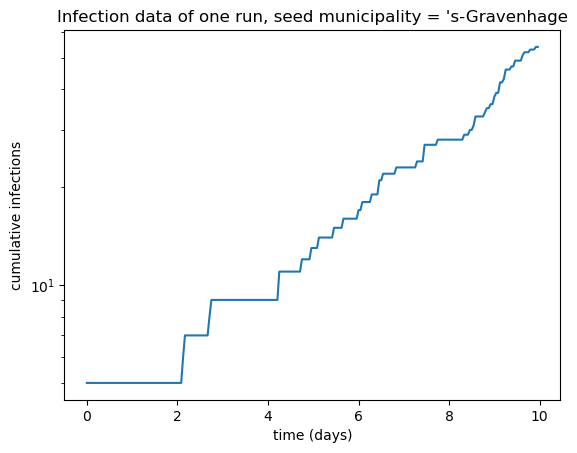

In [5]:
plt.plot(np.arange(timesteps)/24, infected_per_municipality.sum(axis=1))
plt.title(f"Infection data of one run, seed municipality = {uniLocs[MUNI]}")
plt.xlabel("time (days)")
plt.ylabel("cumulative infections")
plt.yscale("log")
plt.show()